In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');

In [9]:
def psd2th_wn(freq,psd,dur,sr):
    def psdinteg(freq,psd):
        f = freq; y = psd;
        ndata = len(y);
        a = np.zeros(ndata-1);
        for i in range(ndata-1):
            n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
            if n == -1:
                a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
            else:
                a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
        return np.sqrt(sum(a))
    def log_interp(x,x_spec,y_spec):
        return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec), left=-10, right=-10);

    tmax = dur;
    fs = fmax * sr;
    dt = 1 / fs

    spec_grms = psdinteg(freq,psd);

    Nt = int(np.ceil(tmax / dt))
    Nt3 = 3 * Nt
    
    # num_fft = 2의 n승
    Nt=2**int(np.ceil(np.log(Nt)/np.log(2)));  
    df = 1. / (Nt * dt);
    
    # White Noise
    wn = np.random.normal(0,1,Nt);
    
    Nf = int(Nt / 2)

    fft_freq = np.linspace(0, (Nf - 1) * df, Nf)
    fft_freq2 = np.linspace(0, (Nt - 1) * df, Nt)
    
    spec = np.zeros(Nf, float)
    sq_spec = np.zeros(Nf, float)
    
    js = 0
    
    if(fft_freq[0]<=0):
        fft_freq[0]=0.5*fft_freq[1];        
    
    sq_spec = np.sqrt(log_interp(fft_freq,freq,psd));
    
    Y = np.zeros(Nt, complex)

    YF = np.fft.fft(wn)
    
    YFn=YF[0:Nf]

    Y[0:Nf]=sq_spec*YFn

    Y[0]=0.
    
    for j in range(1, Nf):
        Y[Nt - j] = complex(Y[j].real, -Y[j].imag)
    
    YI = np.fft.ifft(Y)  
    
    psd_th = YI.real
    
    Nt = len(psd_th)
    
    time = np.linspace(0, (Nt - 1) * dt, Nt)
    
    syn_grms = np.std(psd_th)
    
    psd_th *= (spec_grms / syn_grms)
    
    return time,psd_th;

In [4]:
def psdinteg(freq,psd):
    f = freq; y = psd;
    ndata = len(y);
    a = np.zeros(ndata-1);
    for i in range(ndata-1):
        n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
        if n == -1:
            a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
        else:
            a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
    return np.sqrt(sum(a))

In [5]:
# Smooth PSD
def Gs(f,A1,f1,Q1,A2,f2,Q2,fc):
    out1 = np.zeros(len(f)); out2 = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] <= fc:
            out1[i] = A1/np.sqrt(1+((f1-f[i])**2)/(Q1**2));
            out2[i] = A2/np.sqrt(1+((f2-f[i])**2)/(Q2**2));
        else:
            out1[i] = 0;
            out2[i] = 0;
    out = out1 + out2;
    return out

In [6]:
def G3(f):
    A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
    return Gs(f,A1,f1,Q1,A2,f2,Q2,fc);

In [7]:
A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = fc; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq3 = np.arange(Nf)*df; psd3 = G3(freq3);

In [ ]:
import rainflow

In [114]:
def SN(s):
    b = 1; C = 1e6;
    N  = C/(s**b);
    return N

In [121]:
sr = np.array([1,2,5,8,10,20,40,48]);
pd = np.zeros(len(sr));
for k in range(len(sr)):
    t,th = psd2th_wn(freq3,psd3,1,sr[k]);
    a = rainflow.count_cycles(th);
    cuf = 0;
    for i in range(len(a)):
        N = SN(a[i][0]);
        n = a[i][1];
        cuf += n/N;
    pd[k] = cuf;

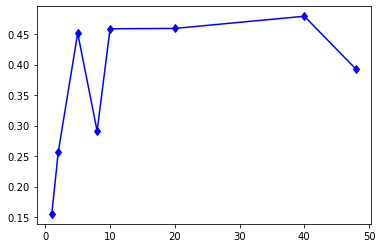

In [122]:
plt.plot(sr,pd,'db-');